In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time


## VS Code, choisir un seul des 3 :

# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
%config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv')
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'day', 'hashed_partner_id',
       'hashed_campaign_id', 'contextid', 'display_env', 'target_env',
       'rtbtypeid', 'rtbadvisibility', 'rtb_detectedlanguage', 'urlhash2',
       'urlhash3', 'urlhash4', 'user_country', 'hashed_affiliateid',
       'hashed_app_id', 'googleviewability', 'googlepagevertical',
       'campaignscenario', 'campaignvertical', 'campaignctrlast24h',
       'is_interstitial', 'dayssincelastvisitdouble',
       'ltf_lastpartnerclicktimestamp', 'ltf_nbglobalclick_4w',
       'ltf_nbglobaldisplay_4w',
       'ltf_nbglobaldisplaysincelastpartnerproductview',
       'ltf_nbpartnerdisplayssincelastclick', 'ltf_nbpartnerclick_4w',
       'ltf_nbpartnerdisplay_4w', 'ltf_nbpartnersales_4w',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplaypartnerapprox_1d_sum_xdevice',
       'nbdisplayaffiliateapprox_1d_sum_xdevice',
       'nbd

In [3]:
# Shuffling
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
# On enlève des variables ltf grâce aux corrélations visibles dans la matrice. 
df_acp = df[['contextid','dayssincelastvisitdouble','campaignctrlast24h','nbdisplay_1hour','nbdayssincelastclick','display_size','nbdisplayglobalapprox_1d_sum_xdevice','is_display_clicked']]
df_acp = df_acp.dropna().reset_index(drop=True)

In [5]:
colors = np.array(['r' if (df_acp['is_display_clicked'][i] == 0) else 'g' for i in range(len(df_acp))])
df_acp = df_acp.drop(['is_display_clicked'], axis=1)

In [6]:
len(df_acp)/len(df)

1.0

In [7]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[ 0.97664678, -0.27118528, -0.78062493, ...,  1.00297679,
        -0.84923462, -0.5009203 ],
       [-1.92104218, -0.44867976, -0.4916739 , ..., -0.44871666,
         2.23773376, -0.02511876],
       [ 1.39060235, -0.42654159,  0.203493  , ...,  1.99276777,
         1.52155709, -0.62084543],
       ...,
       [ 1.39060235, -0.40944189,  0.94959661, ..., -0.40472595,
        -0.84923462,  0.22775808],
       [ 0.14873565,  0.19610921, -0.68762971, ..., -0.44871666,
         1.0029464 , -0.60655852],
       [-0.67917548,  0.65169265, -0.22749968, ..., -0.44871666,
        -0.84923462, -0.63583607]])

In [8]:
acp = PCA(svd_solver='full')

In [9]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

7


In [10]:
print(acp.explained_variance_ratio_)

[0.18284986 0.17321407 0.15878223 0.14281853 0.12531789 0.11502843
 0.10198899]


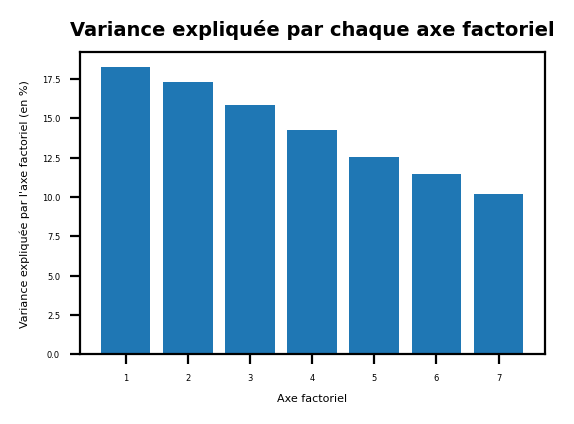

In [11]:
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=3)
plt.figure(figsize=(3,2), dpi=200)
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Variance expliquée par chaque axe factoriel", size=7, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=4)
plt.xlabel("Axe factoriel", size=4)
plt.show()

In [12]:
coord_not_cliqued = [ [] for _ in range(acp.n_components_)]
coord_cliqued = [ [] for _ in range(acp.n_components_)]

for i in range(len(coord[:,0])):
    if df['is_display_clicked'][i] == 0:
        for j in range(acp.n_components_):
            coord_not_cliqued[j].append(coord[i,j])
    else:
        for j in range(acp.n_components_):
            coord_cliqued[j].append(coord[i,j])

In [13]:
def distributions_sur_axe(axe_factoriel):
    s = pd.Series(coord_cliqued[axe_factoriel-1])
    s_not = pd.Series(coord_not_cliqued[axe_factoriel-1])
    fig, ax = plt.subplots(figsize=(4,2), dpi=225)
    s.plot.kde(ax=ax, linewidth=0.5)
    s_not.plot.kde(ax=ax, linewidth=0.5)
    plt.rc('xtick', labelsize=3)
    plt.rc('ytick', labelsize=3)
    plt.title(f"Distribution des observations sur l'axe {axe_factoriel} selon le clic", size=5)
    plt.legend(['Clic','Pas clic'], prop={'size': 5})
    plt.ylabel("")
    plt.show()

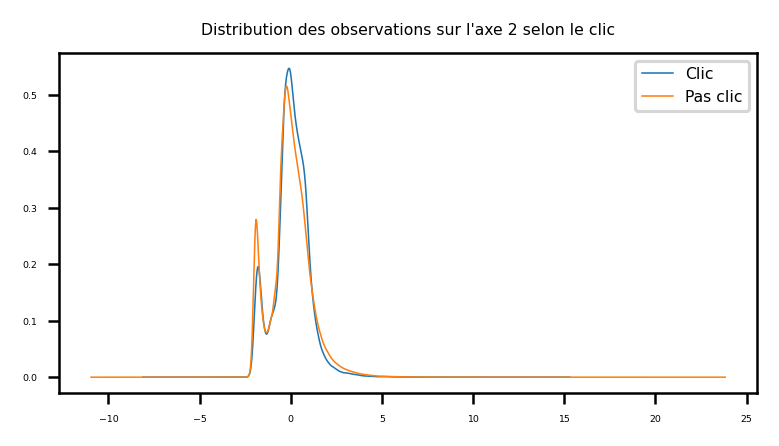

In [14]:
distributions_sur_axe(2)

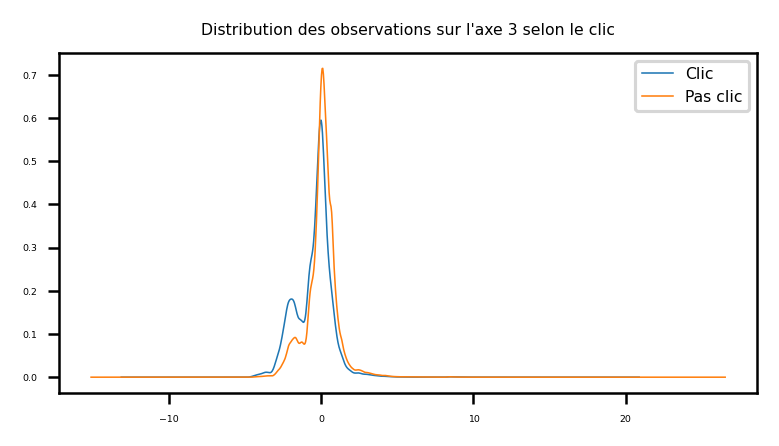

In [15]:
distributions_sur_axe(3)

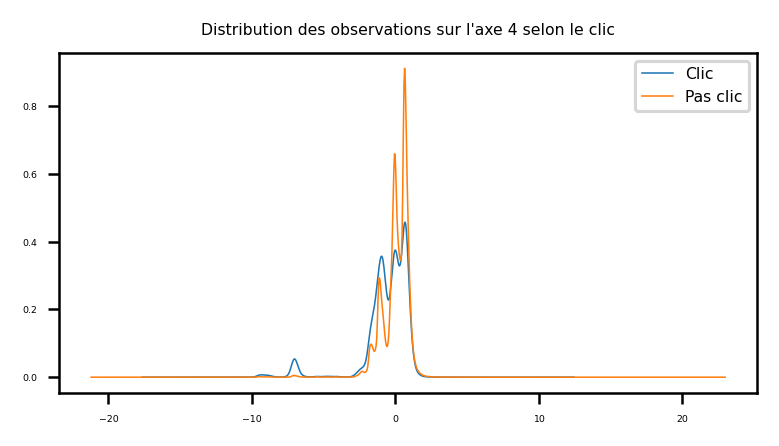

In [16]:
distributions_sur_axe(4)

In [17]:
def affichage_plan_factoriel_equal(i, j, pourcentage=1, equal=False, markersize=0.75, verbose=False):
    """
    pourcentage: proprotion de points à afficher
    equal: si True, autant de points rouges que de points verts
    """
    plt.figure(figsize=(3,2), dpi=225)

    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)   

    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])
        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

       # N_not = int(1/pourcentage)
       # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    plt.plot(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], '.', color='g', linestyle="None", markersize=markersize)
    plt.plot(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], '.', color='r', linestyle="None", markersize=markersize)
    plt.xlabel(f'Axe {i}', size=4)
    plt.ylabel(f'Axe {j}', size=4)
    plt.title(f'Plan (Axe {i}, Axe {j})', size=5)
    plt.legend(['Pas cliqué', 'Cliqué'], prop={'size': 5})
    # plt.savefig('plan_axe1_axe2.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
    # plt.close()
    plt.show()

def affichage_plan_factoriel(i,j):
    plt.figure(figsize=(6,4))
    plt.xlabel(f'Axe {i}')
    plt.ylabel(f'Axe {j}')
    plt.title(f'Plan (Axe {i}, Axe {j})')
    plt.scatter(coord[:,i-1], coord[:,j-1], c=colors, marker=".", s=0.75)
    plt.show()

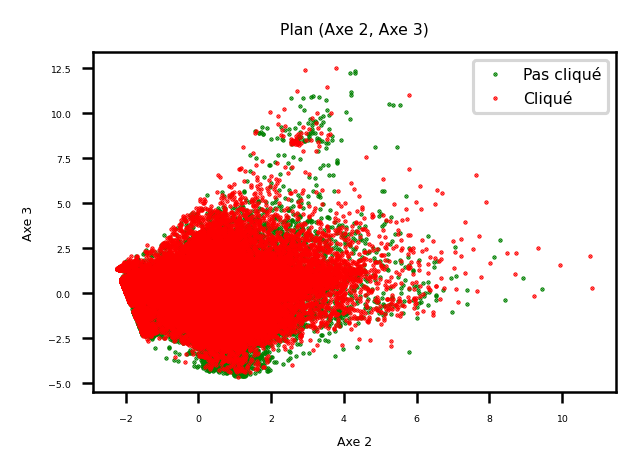

In [18]:
affichage_plan_factoriel_equal(2, 3, equal=True)

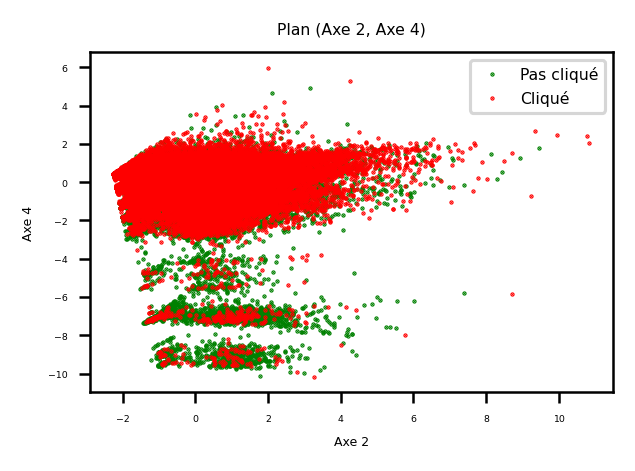

In [19]:
affichage_plan_factoriel_equal(2, 4, equal=True)

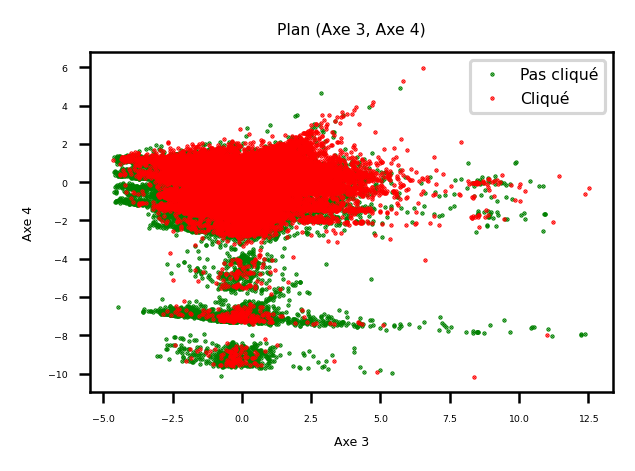

In [20]:
affichage_plan_factoriel_equal(3, 4, equal=True)

In [21]:
# calcul des corrélations
n = len(df_acp)
p = len(df_acp.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

In [22]:
def correlations_sur_axe(axe_factoriel):
    plt.figure(figsize=(3,2), dpi=200)
    plt.rc('xtick', labelsize=3)
    plt.rc('ytick', labelsize=4)
    plt.xticks(rotation=45)
    plt.bar(np.arange(1,acp.n_components_+1), corvar[:,axe_factoriel-1], tick_label=df_acp.columns)
    plt.title(f"Corrélations sur l'axe {axe_factoriel}", size=7, fontweight='bold')
    plt.ylabel(f"Corr(Variable, Axe factoriel {axe_factoriel})", size=6)
    plt.xlabel("Variable", size=6)
    plt.show()

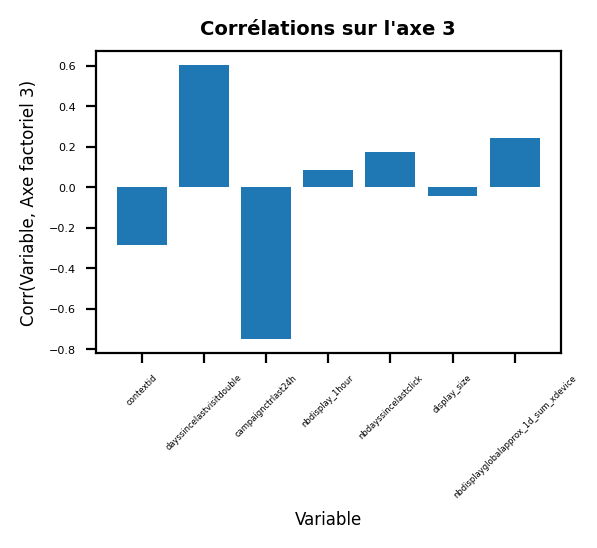

In [23]:
correlations_sur_axe(3)

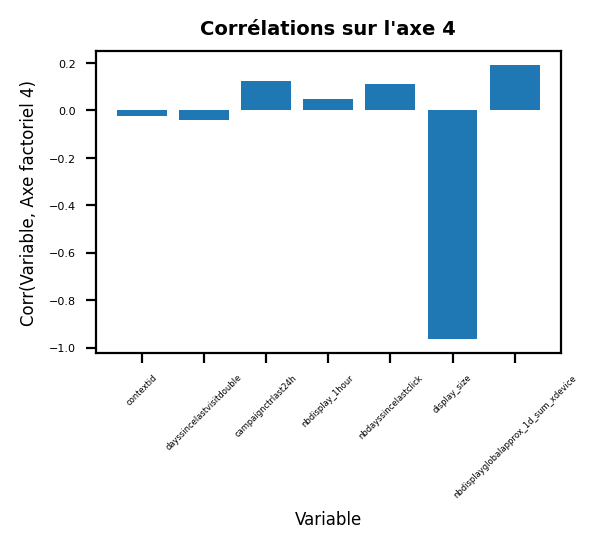

In [24]:
correlations_sur_axe(4)

In [25]:
def affichage_cercle_corr(ax1, ax2):
    fig, axes = plt.subplots(figsize=(3,3), dpi=200)
    axes.set_xlim(-1.05, 1.05)
    axes.set_ylim(-1.05, 1.05)

    for j in range(p):
        axes.arrow(0, 0, corvar[j,ax1-1], corvar[j,ax2-1], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
        plt.annotate(df_acp.columns[j], (corvar[j,ax1-1],corvar[j,ax2-1]), size=4, color='r')

    plt.plot([-1, 1], [0, 0],color='silver', linestyle='-', linewidth=1)
    plt.plot([0, 0], [-1, 1],color='silver', linestyle='-', linewidth=1)

    cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
    axes.add_artist(cercle)

    plt.show()

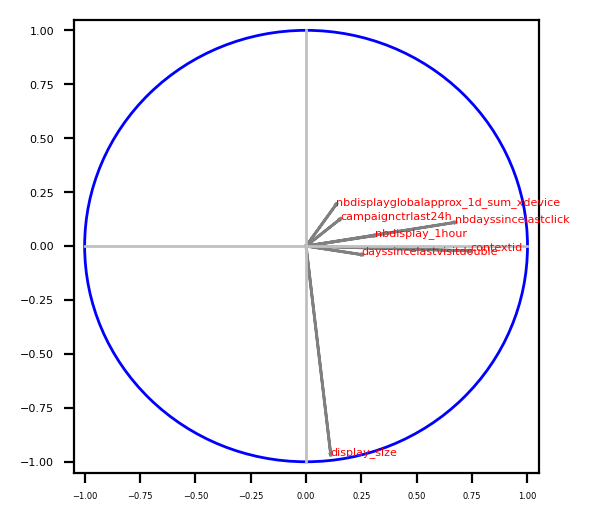

In [26]:
affichage_cercle_corr(2,4)

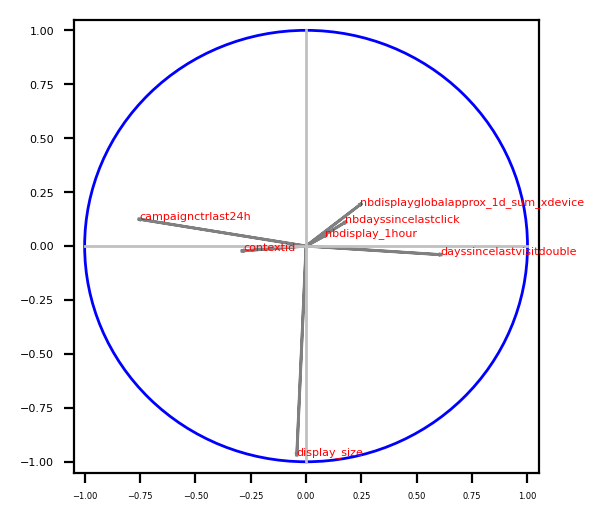

In [27]:
affichage_cercle_corr(3,4)

In [28]:
def affichage_3d_factoriel(i, j, k, pourcentage=1, equal=False, markersize=1, verbose=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    if not equal:
        N_not = int(1/pourcentage)
        N = int(1/pourcentage)
    
    if equal:
        coeff = len(coord_cliqued[0]) / len(coord_not_cliqued[0])

        N_not = int(1/(pourcentage*coeff))
        N = int(1/pourcentage)

        # N_not = int(1/pourcentage)
        # N = int(coeff/pourcentage)

    if verbose:
        print(f"N_not : {N_not}")
        print(f"N : {N}")
        print(f"Nombre de points rouges : {len(coord_not_cliqued[0][::N_not])}")
        print(f"Nombre de points verts : {len(coord_cliqued[0][::N])}")

    ax.scatter(coord_not_cliqued[i-1][::N_not], coord_not_cliqued[j-1][::N_not], coord_not_cliqued[k-1][::N_not], s=markersize, color='r', linestyle="None", marker='o')
    ax.scatter(coord_cliqued[i-1][::N], coord_cliqued[j-1][::N], coord_cliqued[k-1][::N], s=markersize, color='g', linestyle="None", marker='o')
    ax.set_xlabel(f'Axe {i}')
    ax.set_ylabel(f'Axe {j}')
    ax.set_zlabel(f'Axe {k}')
    plt.title(f'Plan (Axe {i}, Axe {j}, Axe {k})')
    plt.legend(['Pas cliqué', 'Cliqué'])
    plt.show()

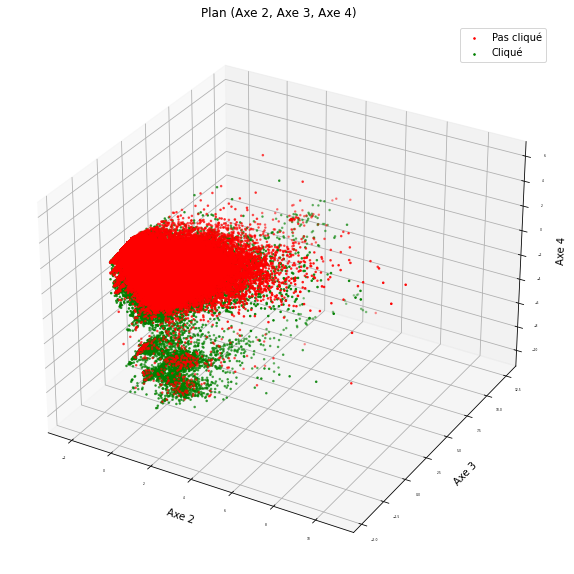

In [29]:
affichage_3d_factoriel(2, 3, 4, equal=True, markersize=2.5)

In [30]:
%matplotlib widget
affichage_3d_factoriel(2, 3, 4, equal=True, markersize=2.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:01:17
